-----------
## In this notebook:
* Create a model using precip vs no precip images
* Model should determine which images contain precipitation
-----------

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


#import warnings
#warnings.filterwarnings("ignore")

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
# define path where images are located
PATH = '/tf/kokamura/Precip/3st-2cl'
data_dir = pathlib.Path(PATH)

# list containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

# set batch size and original image dimensions
batch_size = 80
img_height = 720
img_width = 1280

# total image count
print(image_count)

59207


In [ ]:
# do a quick check and make sure you have image data
files = os.listdir(f'{PATH}/WP')[:10]
img = plt.imread(f'{PATH}/WP/{files[9]}')
plt.imshow(img);
print(img.shape)
# First 4 rows and columns of the image
img[:4,:4]

In [5]:
# create training and validation generators

#reduce dimesionality

train_datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        )
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.2,
        )

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(180,320),
        batch_size=batch_size,
        subset='training',
        seed=123,
        class_mode='binary')
validation_generator = valid_datagen.flow_from_directory(
        data_dir,
        target_size=(180,320),
        batch_size=batch_size,
        subset='validation',
        seed=123,
        class_mode='binary')

Found 47366 images belonging to 2 classes.
Found 11841 images belonging to 2 classes.


In [6]:
# check classs names to make sure you dont have any hidden folders and img dims are correct
class_names = [key for key in train_generator.class_indices]
print(class_names)

['NP', 'WP']


In [ ]:
# display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(15, 15))
images, labels = next(iter(train_generator))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [7]:
# referenced pg 461 of textbook

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 320, 3)),  #rescale input in the [0, 255] range to be in the [0, 1] range
  layers.Conv2D(8, 3, padding='same', activation='elu'),
  layers.Conv2D(8, 3, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 5, padding='same', activation='elu'),
  layers.Conv2D(16, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='elu'),
  layers.Conv2D(32, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='elu'),
  layers.Conv2D(64, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='elu'),
  layers.Conv2D(128, 5, padding='same', activation='elu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(100, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(50, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(10, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation='softmax')
])

In [8]:
opt = keras.optimizers.Adam(learning_rate=4e-3)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
# view all the layers of the network using the model's summary method:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 320, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 320, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 160, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 160, 16)       3216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 160, 16)       6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 80, 16)        0

In [10]:
epochs=10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

# 3.5 hours

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
592/592 [==============================] - 1336s 2s/step - loss: 39.3738 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/10
592/592 [==============================] - 1271s 2s/step - loss: 1.1589 - accuracy: 0.4956 - val_loss: 0.6936 - val_accuracy: 0.4983
Epoch 3/10
592/592 [==============================] - 1334s 2s/step - loss: 1.0394 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 4/10
592/592 [==============================] - 1335s 2s/step - loss: 0.9597 - accuracy: 0.4973 - val_loss: 0.6949 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1261s 2s/step - loss: 0.8745 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 6/10
592/592 [==============================] - 1230s 2s/step - loss: 0.7997 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
592/592 [==============================] - 1232s 2s/step - loss: 0.7559 - accuracy: 0.4992 - val_loss: 0.6939 - val_accuracy

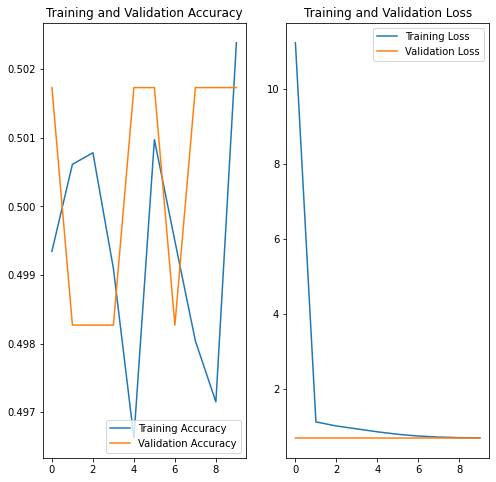

In [11]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.4904773 0.5095227]]
This image most likely belongs to WP with a 50.48 percent confidence.


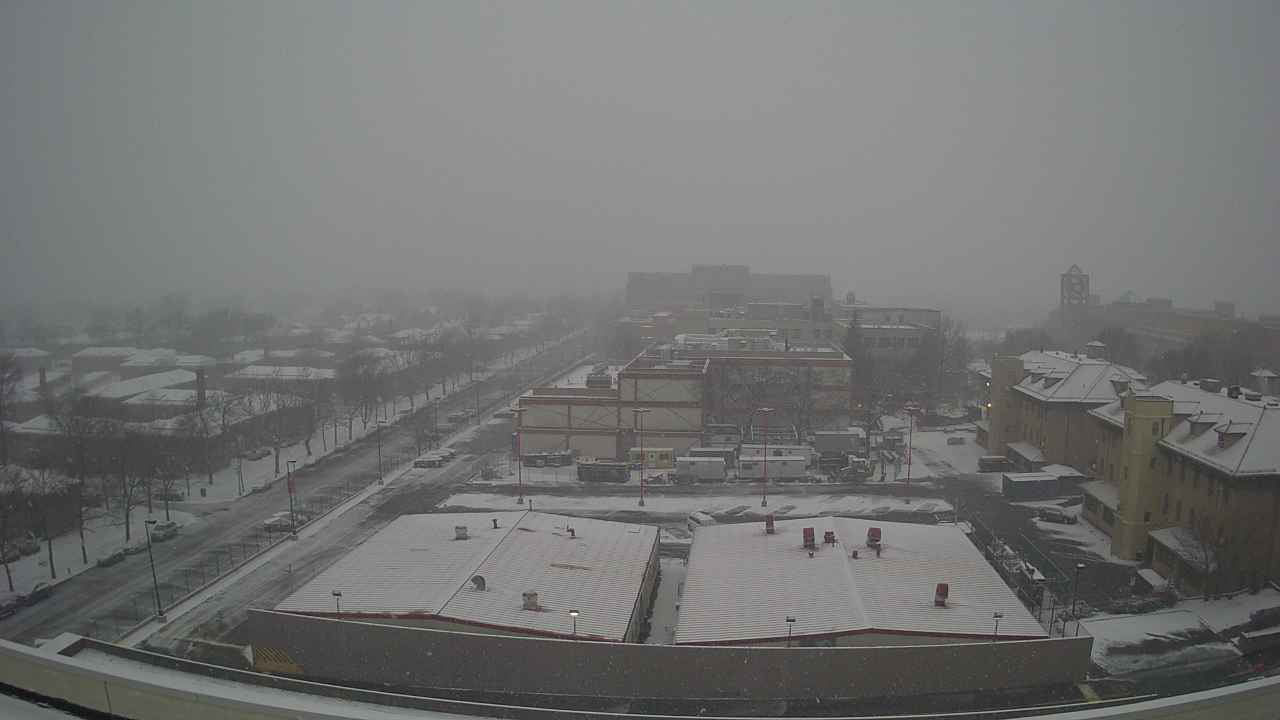

In [12]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [14]:
epochs=10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1258s 2s/step - loss: 0.6944 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 2/10
592/592 [==============================] - 1274s 2s/step - loss: 0.6938 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 3/10
592/592 [==============================] - 1351s 2s/step - loss: 0.6937 - accuracy: 0.4997 - val_loss: 0.6937 - val_accuracy: 0.5017
Epoch 4/10
592/592 [==============================] - 1292s 2s/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1294s 2s/step - loss: 0.6943 - accuracy: 0.4980 - val_loss: 0.6945 - val_accuracy: 0.4983
Epoch 6/10
592/592 [==============================] - 1279s 2s/step - loss: 0.6942 - accuracy: 0.5044 - val_loss: 0.6934 - val_accuracy: 0.4983
Epoch 7/10
592/592 [==============================] - 1312s 2s/step - loss: 0.6946 - accuracy: 0.4971 - val_loss: 0.6939 - val_accuracy:

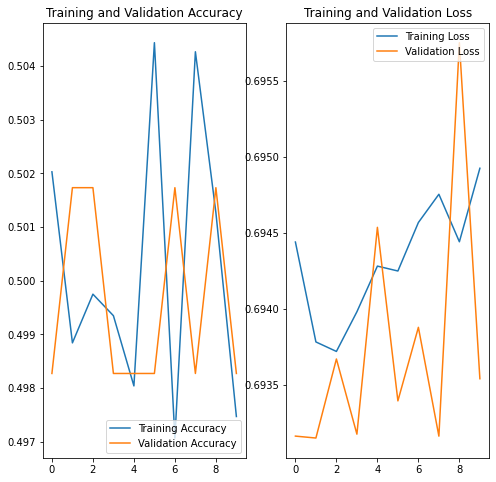

In [15]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.5123645  0.48763546]]
This image most likely belongs to NP with a 50.62 percent confidence.


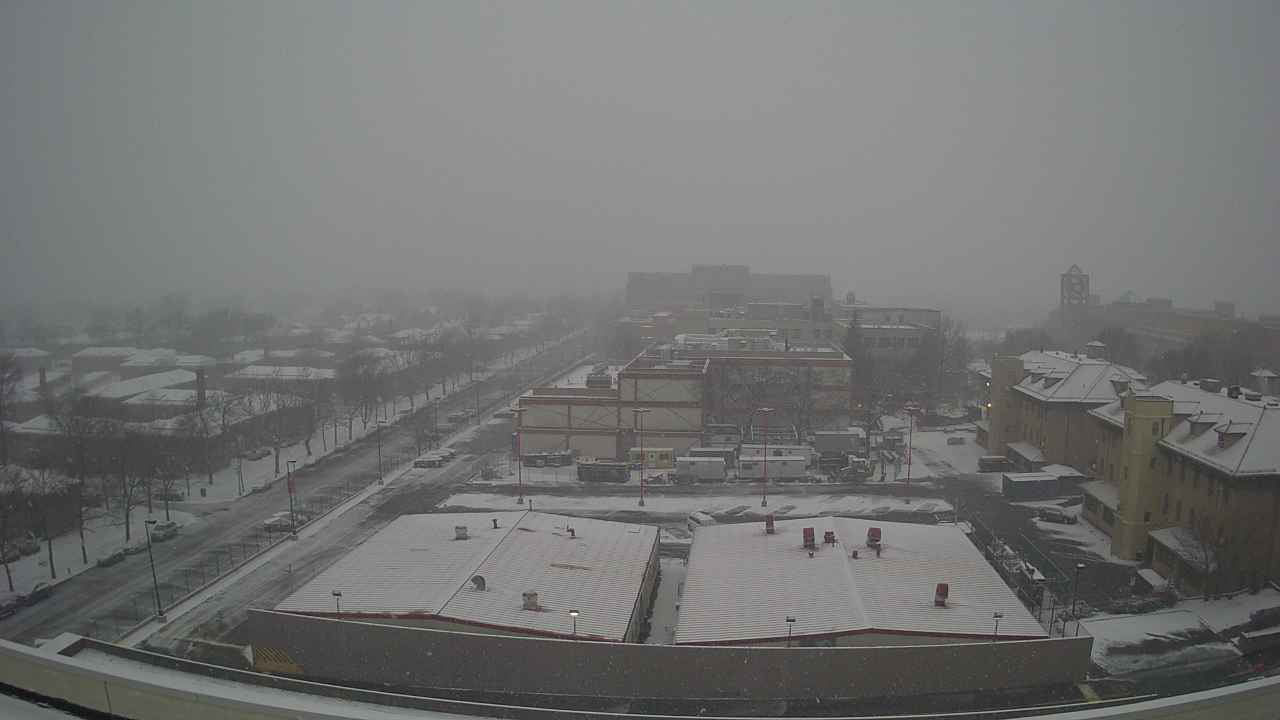

In [16]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [17]:
epochs=10
more_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1198s 2s/step - loss: 0.6943 - accuracy: 0.5040 - val_loss: 0.6960 - val_accuracy: 0.4983
Epoch 2/10
592/592 [==============================] - 1256s 2s/step - loss: 0.6950 - accuracy: 0.4991 - val_loss: 0.6958 - val_accuracy: 0.5017
Epoch 3/10
592/592 [==============================] - 1299s 2s/step - loss: 0.6951 - accuracy: 0.4987 - val_loss: 0.6944 - val_accuracy: 0.4983
Epoch 4/10
592/592 [==============================] - 1236s 2s/step - loss: 0.6954 - accuracy: 0.5061 - val_loss: 0.6939 - val_accuracy: 0.5017
Epoch 5/10
592/592 [==============================] - 1194s 2s/step - loss: 0.6951 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 6/10
592/592 [==============================] - 1251s 2s/step - loss: 0.6952 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 7/10
592/592 [==============================] - 1347s 2s/step - loss: 0.6958 - accuracy: 0.5007 - val_loss: 0.6934 - val_accuracy:

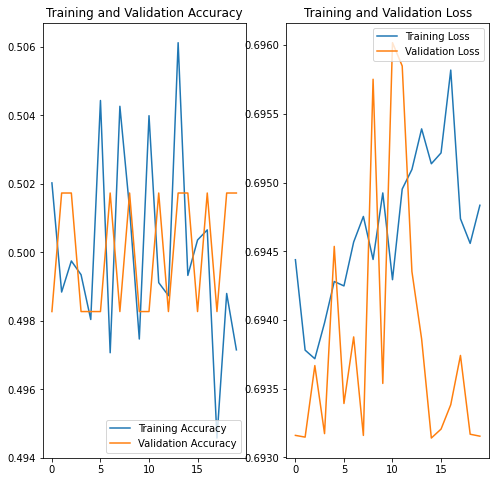

In [19]:
# visualize training results
acc += more_history.history['accuracy']
val_acc += more_history.history['val_accuracy']

loss += more_history.history['loss']
val_loss += more_history.history['val_loss']

epochs_range = range(epochs*2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.4956511  0.50434893]]
This image most likely belongs to WP with a 50.22 percent confidence.


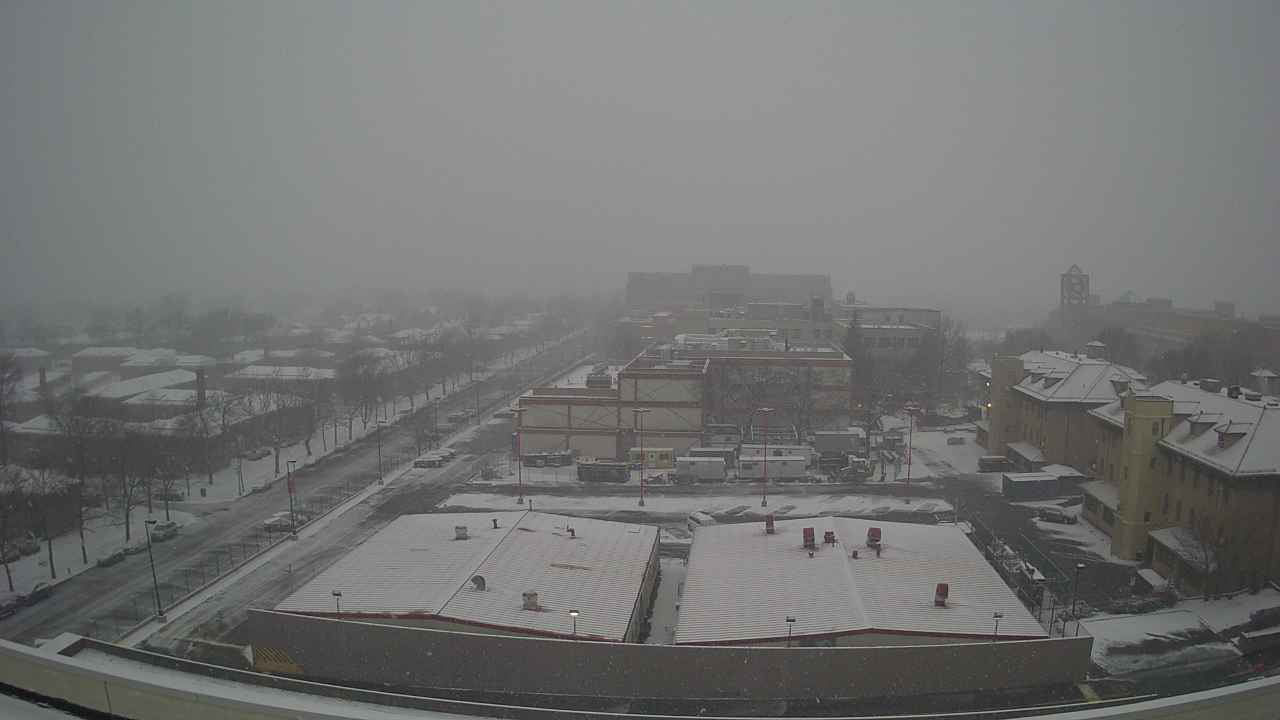

In [20]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [21]:
epochs=10
two_more_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1407s 2s/step - loss: 0.6948 - accuracy: 0.5004 - val_loss: 0.6961 - val_accuracy: 0.5017
Epoch 3/10
592/592 [==============================] - 1345s 2s/step - loss: 0.6948 - accuracy: 0.4979 - val_loss: 0.6940 - val_accuracy: 0.5017
Epoch 4/10
592/592 [==============================] - 1351s 2s/step - loss: 0.6949 - accuracy: 0.5028 - val_loss: 0.6939 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1312s 2s/step - loss: 0.6966 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 6/10
592/592 [==============================] - 1374s 2s/step - loss: 0.6945 - accuracy: 0.5008 - val_loss: 0.6960 - val_accuracy: 0.5017
Epoch 7/10
592/592 [==============================] - 1342s 2s/step - loss: 0.6948 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 9/10
592/592 [==============================] - 1333s 2s/step - loss: 0.6944 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy:

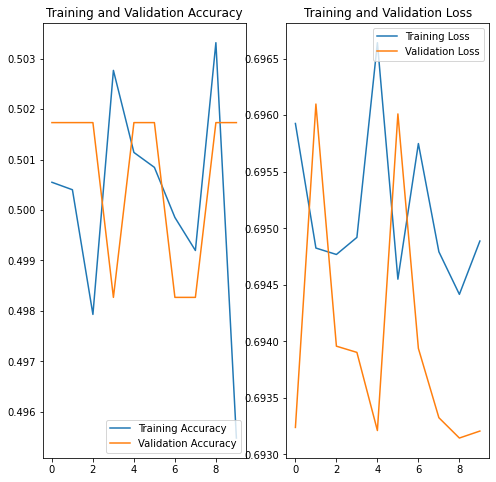

In [24]:
# visualize training results
acc = two_more_history.history['accuracy']
val_acc = two_more_history.history['val_accuracy']

loss = two_more_history.history['loss']
val_loss = two_more_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
epochs=10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1346s 2s/step - loss: 0.6946 - accuracy: 0.4996 - val_loss: 0.6947 - val_accuracy: 0.5017
Epoch 2/10
592/592 [==============================] - 1258s 2s/step - loss: 0.6947 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 3/10
592/592 [==============================] - 1245s 2s/step - loss: 0.6948 - accuracy: 0.5022 - val_loss: 0.6939 - val_accuracy: 0.5017
Epoch 4/10
592/592 [==============================] - 1273s 2s/step - loss: 0.6949 - accuracy: 0.4999 - val_loss: 0.6939 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1306s 2s/step - loss: 0.6949 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 6/10
592/592 [==============================] - 1263s 2s/step - loss: 0.6949 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 7/10
592/592 [==============================] - 1300s 2s/step - loss: 0.6949 - accuracy: 0.4947 - val_loss: 0.6937 - val_accuracy:

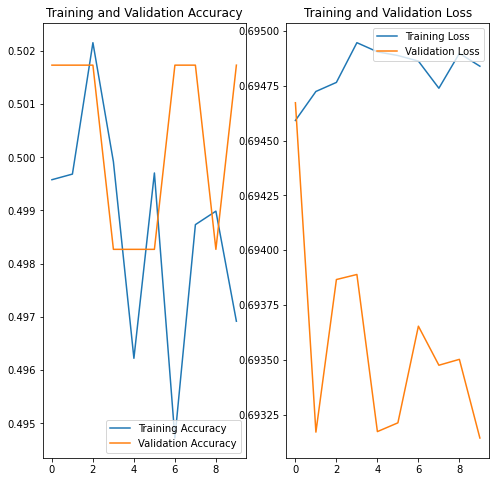

In [26]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
epochs=10
history_6 = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1261s 2s/step - loss: 0.6946 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 2/10
592/592 [==============================] - 1308s 2s/step - loss: 0.6948 - accuracy: 0.4973 - val_loss: 0.6940 - val_accuracy: 0.4983
Epoch 3/10
592/592 [==============================] - 1329s 2s/step - loss: 0.6946 - accuracy: 0.5014 - val_loss: 0.6936 - val_accuracy: 0.5017
Epoch 4/10
592/592 [==============================] - 1341s 2s/step - loss: 0.6959 - accuracy: 0.5016 - val_loss: 0.6935 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1331s 2s/step - loss: 0.6948 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 6/10
592/592 [==============================] - 1342s 2s/step - loss: 0.6947 - accuracy: 0.4962 - val_loss: 0.6938 - val_accuracy: 0.5017
Epoch 7/10
592/592 [==============================] - 1358s 2s/step - loss: 0.6948 - accuracy: 0.4996 - val_loss: 0.6939 - val_accuracy:

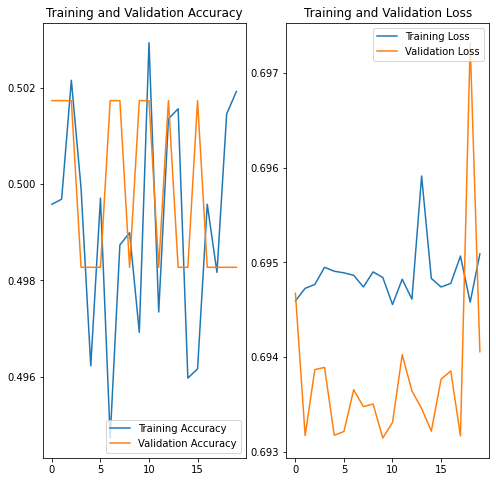

In [28]:
# visualize training results
acc += history_6.history['accuracy']
val_acc += history_6.history['val_accuracy']

loss += history_6.history['loss']
val_loss += history_6.history['val_loss']

epochs_range = range(epochs*2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.51963365 0.48036632]]
This image most likely belongs to NP with a 50.98 percent confidence.


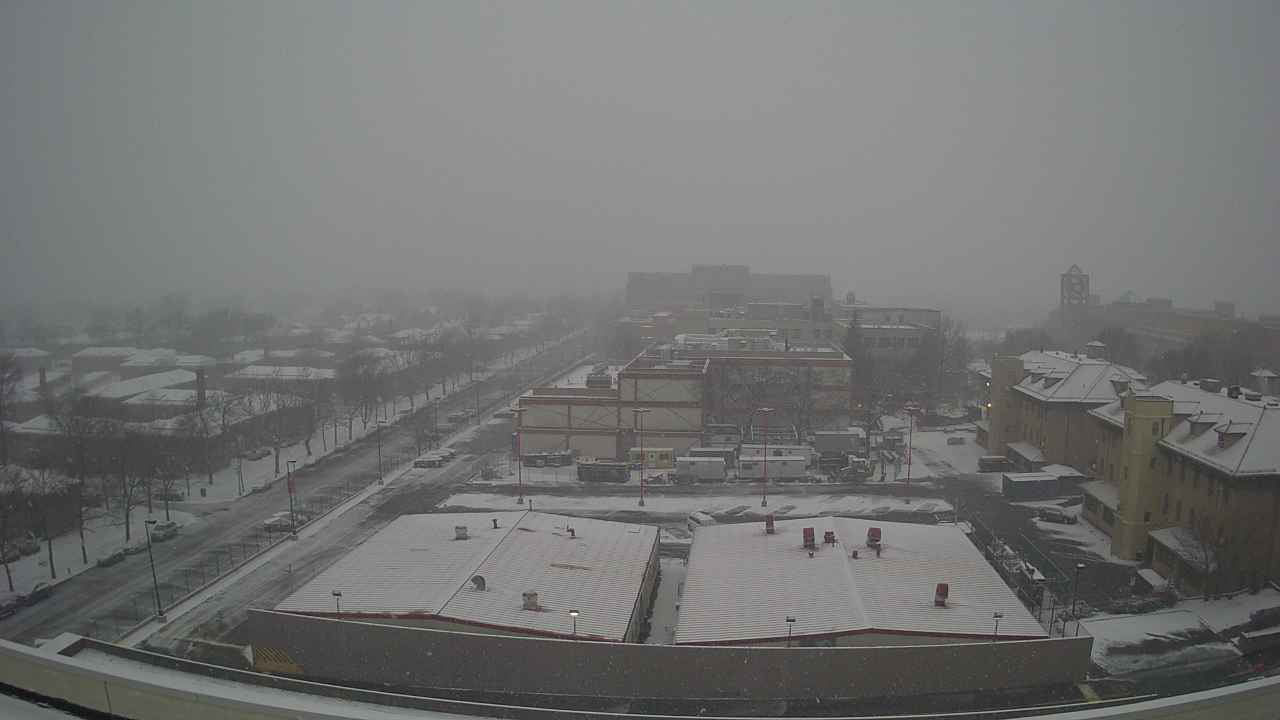

In [29]:
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/11/17/QUEE/20201117T221534_QUEE.jpg' # no precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/03/23/ANDE/20200323T212526_ANDE.jpg' # with precip
#'/tf/NYSM/archive/nysm/cam_photos/2020/04/13/QUEE/20200413T140029_QUEE.jpg' # with precip
# 


img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(180, 320)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [30]:
epochs=10
history_7 = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1354s 2s/step - loss: 0.6946 - accuracy: 0.4996 - val_loss: 0.6956 - val_accuracy: 0.4983
Epoch 2/10
592/592 [==============================] - 1336s 2s/step - loss: 0.6948 - accuracy: 0.5004 - val_loss: 0.6936 - val_accuracy: 0.5017
Epoch 3/10
592/592 [==============================] - 1345s 2s/step - loss: 0.6947 - accuracy: 0.4992 - val_loss: 0.6941 - val_accuracy: 0.4983
Epoch 4/10
592/592 [==============================] - 1352s 2s/step - loss: 0.6948 - accuracy: 0.4972 - val_loss: 0.6948 - val_accuracy: 0.4983
Epoch 5/10
592/592 [==============================] - 1349s 2s/step - loss: 0.6945 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 6/10
592/592 [==============================] - 1359s 2s/step - loss: 0.6951 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
592/592 [==============================] - 1377s 2s/step - loss: 0.6950 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy:

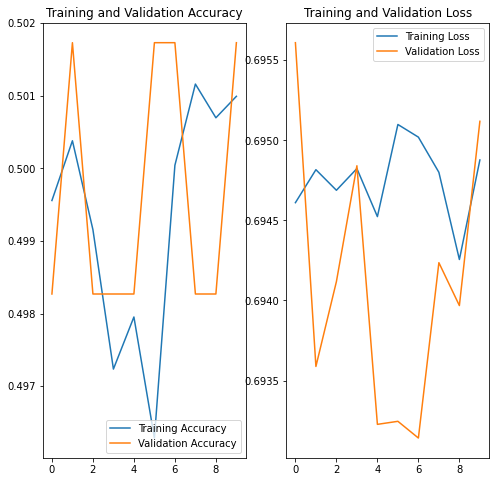

In [31]:
# visualize training results
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']

loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
epochs=10
history_8 = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=(np.ceil(image_count*0.8))/batch_size,
    validation_steps=(np.floor(image_count*0.2))/batch_size,
    epochs=epochs
    )

Epoch 1/10
592/592 [==============================] - 1369s 2s/step - loss: 0.6950 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 2/10
592/592 [==============================] - 1340s 2s/step - loss: 0.6947 - accuracy: 0.5002 - val_loss: 0.6936 - val_accuracy: 0.4983
Epoch 3/10
592/592 [==============================] - 1343s 2s/step - loss: 0.6949 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/10
592/592 [==============================] - 1353s 2s/step - loss: 0.6948 - accuracy: 0.4988 - val_loss: 0.6943 - val_accuracy: 0.4983
Epoch 6/10
592/592 [==============================] - 1326s 2s/step - loss: 0.6948 - accuracy: 0.4987 - val_loss: 0.6943 - val_accuracy: 0.4983
Epoch 7/10
592/592 [==============================] - 1328s 2s/step - loss: 0.6948 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.4983
Epoch 8/10
592/592 [==============================] - 1343s 2s/step - loss: 0.6945 - accuracy: 0.5045 - val_loss: 0.6937 - val_accuracy:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# visualize training results
acc = history_8.history['accuracy']
val_acc = history_8.history['val_accuracy']

loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()